##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Регрессия: Спрогнозируй эффективность расхода топлива

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />Смотрите на TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/ru/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Запустите в Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/ru/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />Изучайте код на GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/ru/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Скачайте ноутбук</a>
  </td>
</table>

Note: Вся информация в этом разделе переведена с помощью русскоговорящего Tensorflow сообщества на общественных началах. Поскольку этот перевод не является официальным, мы не гарантируем что он на 100% аккуратен и соответствует [официальной документации на английском языке](https://www.tensorflow.org/?hl=en). Если у вас есть предложение как исправить этот перевод, мы будем очень рады увидеть pull request в [tensorflow/docs](https://github.com/tensorflow/docs) репозиторий GitHub. Если вы хотите помочь сделать документацию по Tensorflow лучше (сделать сам перевод или проверить перевод подготовленный кем-то другим), напишите нам на [docs-ru@tensorflow.org list](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ru).

В задаче *регрессии*, мы хотим дать прогноз какого-либо непрерывного значения, например цену или вероятность. Сравните это с задачей *классификации*, где нужно выбрать конкретную категорию из ограниченного списка (например, есть ли на картинке яблоко или апельсин, распознайте какой фрукт на изображении).

Этот урок использует классический датасет [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) и строит модель, предсказывающую эффективность расхода топлива автомобилей конца 70-х и начала 80-х. Чтобы сделать это, мы предоставим модели описания множества различных автомобилей того времени. Эти описания будут содержать такие параметры как количество цилиндров, лошадиных сил, объем двигателя и вес.

В этом примере используется tf.keras API, подробнее [смотри здесь](https://www.tensorflow.org/guide/keras).

In [3]:
# Установим библиотеку seaborn для построения парных графиков
!pip install -q seaborn

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


## Датасет Auto MPG

Датасет доступен в [репозитории машинного обучения UCI](https://archive.ics.uci.edu/ml/).



### Получите данные
Сперва загрузим датасет.

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 1us/step


'/home/kbuilder/.keras/datasets/auto-mpg.data'

Импортируем его при помощи библиотеки Pandas:

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Подготовьте данные

Датасет содержит несколько неизвестных значений.

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Чтобы урок оставался простым, удалим эти строки.

In [8]:
dataset = dataset.dropna()

Столбец `"Origin"` на самом деле категорийный, а не числовой. Поэтому конвертируем его в one-hot

In [9]:
origin = dataset.pop('Origin')

In [10]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Разделите данные на обучающую и тестовую выборки

Сейчас разделим датасет на обучающую и тестовую выборки.

Тестовую выборку будем использовать для итоговой оценки нашей модели

In [11]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Проверьте данные

Посмотрите на совместное распределение нескольких пар колонок из тренировочного набора данных:

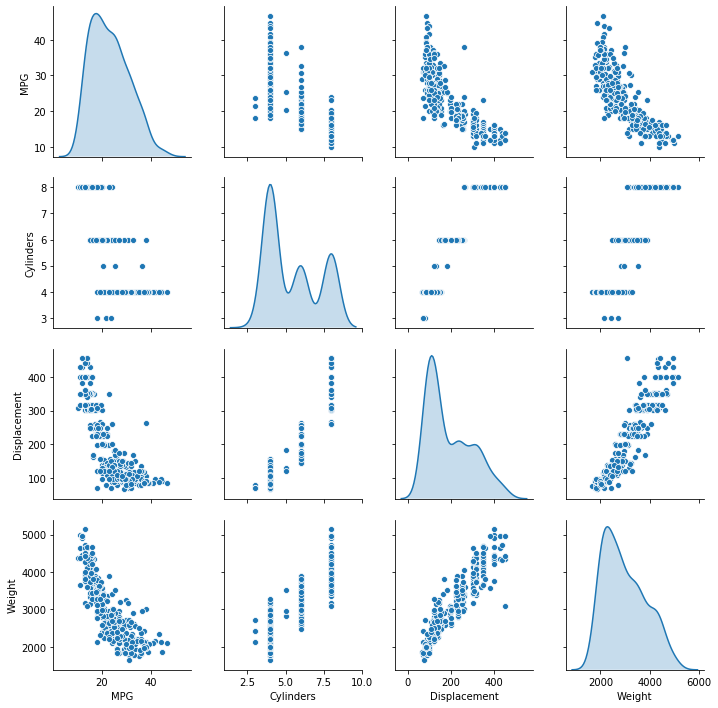

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Также посмотрите на общую статистику:

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Отделите признаки от меток

Отделите целевые значения или "метки" от признаков. Обучите модель для предсказания значений.

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Нормализуйте данные

Взгляните еще раз на блок train_stats приведенный выше. Обратите внимание на то, как отличаются диапазоны каждого из признаков.

Это хорошая практика - нормализовать признаки у которых различные масштабы и диапазон изменений. Хотя модель *может* сходиться и без нормализации признаков, обучение при этом усложняется и итоговая модель становится зависимой от выбранных единиц измерения входных данных..

Примечание. Мы намеренно генерируем эти статистические данные только из обучающей выборки, они же будут использоваться для нормализации тестовой выборки. Мы должны сделать это, чтобы тестовая выборка была из того распределения на которой обучалась модель.

In [15]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Для обучения модели мы будем использовать эти нормализованные данные.

Внимание: статистики использованные для нормализации входных данных (среднее и стандартное отклонение) должны быть применены к любым другим данным, которые используются в модели. Это же касается one-hot кодирования которое мы делали ранее. Преобразования необходимо применять как к тестовым данным, так и к данным с которыми модель используется в работе.

## Модель

### Постройте модель

Давайте построим нашу модель. Мы будем использовать `Sequential` (последовательную) модель с двумя полносвязными скрытыми слоями, а выходной слой будет возвращать одно непрерывное значение. Этапы построения модели мы опишем в функции build_model, так как позже мы создадим еще одну модель.

In [16]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [17]:
model = build_model()

### Проверьте модель

Используйте метод `.summary` чтобы напечатать простое описание модели.

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________



Сейчас попробуем нашу модель. Возьмем пакет из`10` примеров из обучающей выборки и вызовем `model.predict` на них.

In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.04119337],
       [-0.01038301],
       [ 0.01377624],
       [-0.25862625],
       [-0.667559  ],
       [ 0.13513853],
       [-0.7113681 ],
       [ 0.26594675],
       [ 0.06332049],
       [-0.53952515]], dtype=float32)

Похоже все работает правильно, модель показывает результат ожидаемой размерности и типа.

### Обучите модель

Обучите модель за 1000 эпох и запишите точность модели на тренировочных и проверочных данных в объекте `history`.

In [20]:
# Выведем прогресс обучения в виде точек после каждой завершенной эпохи
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Визуализируйте процесс обучения модели используя статистику содержащуюся в объекте `history`.

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.504612,1.021514,2.504612,9.612599,2.349458,9.612599,995
996,2.662208,0.987722,2.662208,9.540146,2.304781,9.540146,996
997,2.823853,1.045893,2.823853,9.467104,2.325295,9.467103,997
998,2.791825,1.056888,2.791825,9.474766,2.307261,9.474767,998
999,2.583741,1.013137,2.583741,9.505647,2.353101,9.505647,999


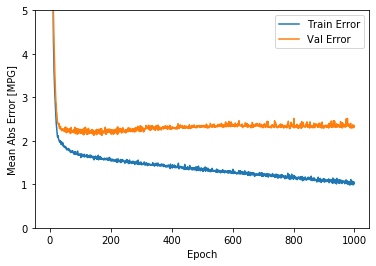

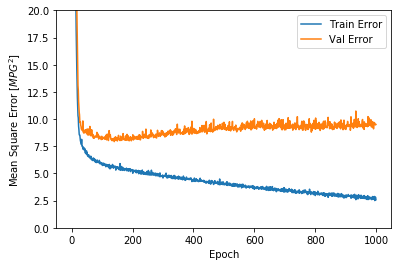

In [22]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Полученный график показывает, небольшое улучшение или даже деградацию ошибки валидации после примерно 100 эпох обучения. Давай обновим метод model.fit чтобы автоматически прекращать обучение когда ошибка валидации Val loss прекращает улучшаться. Для этого используем функцию *EarlyStopping callback* которая проверяет показатели обучения после каждой эпохи. Если после определенного количество эпох нет никаких улучшений, то функция автоматически остановит обучение.

Вы можете больше узнать про этот коллбек [здесь](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).


................................................................................

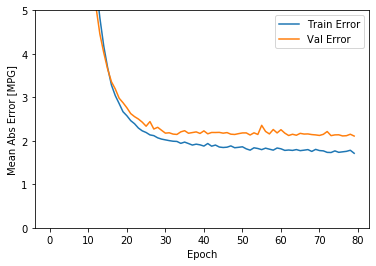

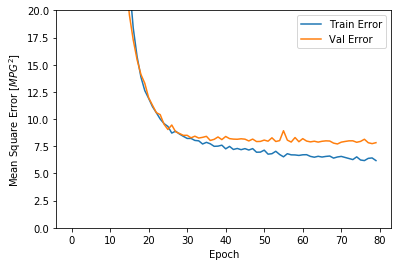

In [23]:
model = build_model()

# Параметр patience определяет количество эпох, проверяемых на улучшение
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

График показывает что среднее значение ошибки на проверочных данных - около 2 галлонов на милю. Хорошо это или плохо? Решать тебе.

Давай посмотрим как наша модель справится на **тестовой** выборке, которую мы еще не использовали при обучении модели. Эта проверка покажет нам какого результата ожидать от модели, когда мы будем ее использовать в реальном мире

In [24]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.7634 - mae: 1.9195 - mse: 5.7634
Testing set Mean Abs Error:  1.92 MPG


### Сделайте прогноз

Наконец, спрогнозируйте значения миль-на-галлон используя данные из тестовой выборки:

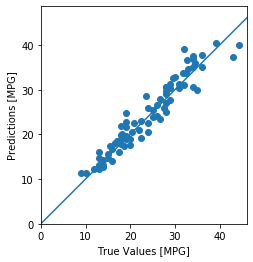

In [25]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Вроде наша модель дает хорошие предсказания. Давайте посмотрим распределение ошибки.

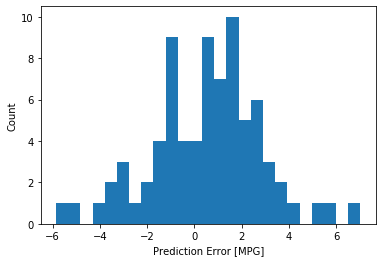

In [26]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Она не достаточно гауссова, но мы могли это предполагать потому что количество примеров очень мало.

## Заключение

Это руководство познакомило тебя с несколькими способами решения задач регрессии.

* Среднеквадратичная ошибка (MSE) это распространенная функция потерь используемая для задач регрессии (для классификации используются другие функции).
* Аналогично, показатели оценки модели для регрессии отличаются от используемых в классификации. Обычной метрикой для регрессии является средняя абсолютная ошибка (MAE).
* Когда значения числовых входных данных из разных диапазонов, каждый признак должен быть незавизимо масштабирован до одного и того же диапазона.
* Если данных для обучения немного, используй небольшую сеть из нескольких скрытых слоев. Это поможет избежать переобучения.
* Метод ранней остановки очень полезная техника для избежания переобучения.